In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from tabulate import tabulate
from astropy.time import Time
from tqdm import tqdm
import csv

In [3]:
def set_filter(file, start, stop, drift_max=0, snr_max=50, beam_val=2 ):
    # Load and slice dataset
    global df_new
    df = pd.read_pickle(f"/datag/users/ctremblay/{file}")
   # print(df.columns)
    small_df = df[start:stop]

    # Select relevant columns
    columns = ['file_uri', 'observation_id','source_name', 'beam_id', 'ra_hours', 'dec_degrees', 'tstart',
               'signal_frequency', 'signal_beam', 'signal_drift_rate', 'signal_snr',
               'signal_power', 'signal_incoherent_power']
    df_new = small_df[columns]

    # Apply filtering thresholds
    df_new = df_new[(df_new['signal_drift_rate'] != drift_max) &
                    (df_new['signal_snr'] <= snr_max)]
    
    #print(f"Total filtered hits: {len(df_new)}")

    return df_new



In [ ]:
#rfi filtering based on power ratio and overlapping frequency in fov 
def processing(file, start, stop):
    df_new = set_filter(file, start, stop)
    # rounding to help with determining overlap not as specific as 5 decimals 
    df_new['signal_frequency'] = df_new['signal_frequency'].round(3)

    fov_group = df_new.groupby('file_uri')
    all_fov_dfs = []

    for file_uri, fov_df in fov_group:
        fov_df = fov_df.copy()  # avoid SettingWithCopyWarning
        fov_df['rfi_flag'] = False  # initialize all False
        fov_df['flag_strength']=0
        

        # Flag overlapping frequencies at same tstart
        grouped_time = fov_df.groupby('tstart')
        overlap_indices = []
        for t_value, t_df in grouped_time:
            freq_counts = t_df['signal_frequency'].value_counts()
            overlapping_freqs = freq_counts[freq_counts > 1]
            for freq in overlapping_freqs.index:
                hits = t_df[t_df['signal_frequency'] == freq]
                overlap_indices.extend(hits.index.tolist())

        # Set rfi_flag True for overlapping hits
        fov_df.loc[overlap_indices, 'rfi_flag'] = True
        fov_df.loc[overlap_indices, 'flag_strength'] += 1
        

        # Power ratio flagging of entire FOV if condition met
        for idx, row in fov_df.iterrows():
            incoh = row['signal_incoherent_power']
            coh = row['signal_power']
            if incoh > 0 and (coh / incoh) > 2.5:

                fov_df.at[idx, 'rfi_flag'] = True  # Flag only this hit
                fov_df.at[idx, 'flag_strength'] += 1

        #flagging overlapping beam detections 
        unique_freqs=sorted(fov_df["signal_frequency"].unique())

        pre_beam_flags = fov_df['rfi_flag'].sum()  # how many are already flagged

        beam_flag_count = 0  # count how many get flagged by beam logic

        for freq in unique_freqs:
            freq_subset = fov_df[fov_df['signal_frequency'] == freq]
            unique_beams = freq_subset['signal_beam'].unique()
            if len(unique_beams) > 3:
                already_flagged = fov_df.loc[freq_subset.index, 'rfi_flag'].sum()
                total = len(freq_subset)
                #print(f"Freq {freq}: {already_flagged}/{total} already flagged")
                to_update = freq_subset.index

                fov_df.loc[freq_subset.index, 'rfi_flag'] = True
                fov_df.loc[to_update, 'flag_strength'] += 1

                beam_flag_count += total
                # After beam-flagging loop
            post_beam_flags = fov_df['rfi_flag'].sum()
            new_flags = post_beam_flags - pre_beam_flags

    

        all_fov_dfs.append(fov_df)
    full_df = pd.concat(all_fov_dfs, ignore_index=True)
    #print(full_df.groupby('rfi_flag').size())

    return full_df

#processing('Summer_Project_RA9_Dec0.90.pkl', 0, 1000000)


In [5]:
full_df = processing('Summer_Project_RA9_Dec0.90.pkl', 0, 1000000)


In [ ]:
# dividing up df based on flags 
full_df.groupby('flag_strength').size()
clean_df = full_df[full_df['flag_strength'] == 0]         # High-confidence real
maybe_rfi = full_df[full_df['flag_strength'] == 1]        # Weak RFI flag
strong_rfi = full_df[full_df['flag_strength'] >= 2]       # Remove from science set

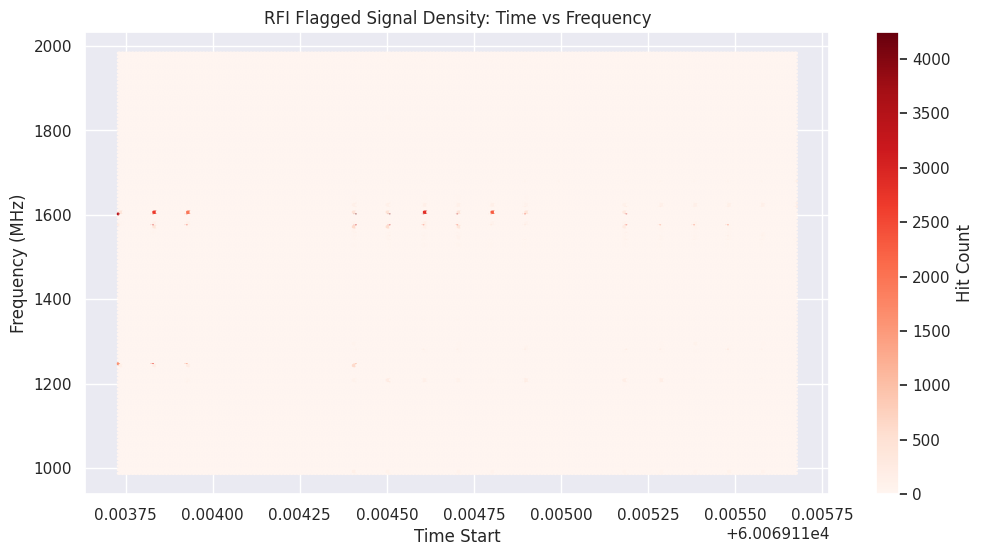

In [37]:
# signal density/ timevs freq
rfi_only = full_df[full_df['rfi_flag']==True]
plt.figure(figsize=(12, 6))
plt.hexbin(rfi_only['tstart'], rfi_only['signal_frequency'], gridsize=200, cmap='Reds')
plt.xlabel("Time Start")
plt.ylabel("Frequency (MHz)")
plt.title("RFI Flagged Signal Density: Time vs Frequency")
plt.colorbar(label='Hit Count')
plt.show()

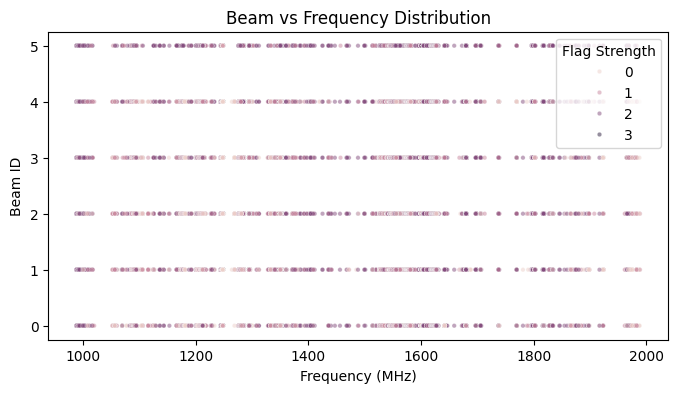

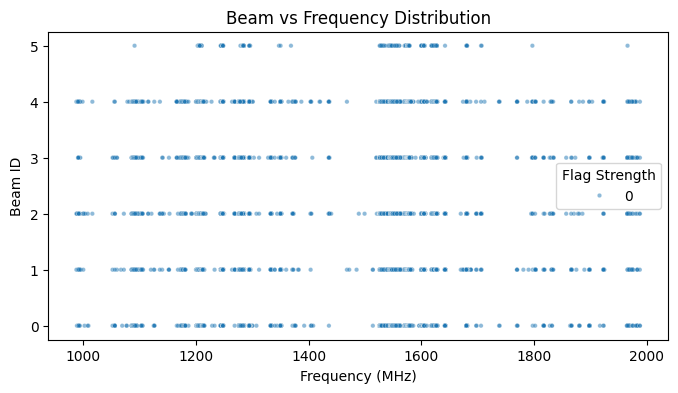

In [8]:

plt.figure(figsize=(8, 4))
sns.scatterplot(data=full_df, x='signal_frequency', y='signal_beam', hue='flag_strength', s=10, alpha=0.5)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Beam ID")
plt.title("Beam vs Frequency Distribution")
plt.legend(title='Flag Strength')
plt.show()

plt.figure(figsize=(8, 4))
sns.scatterplot(data=clean_df, x='signal_frequency', y='signal_beam', hue='flag_strength', s=10, alpha=0.5)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Beam ID")
plt.title("Beam vs Frequency Distribution")
plt.legend(title='Flag Strength')
plt.show()

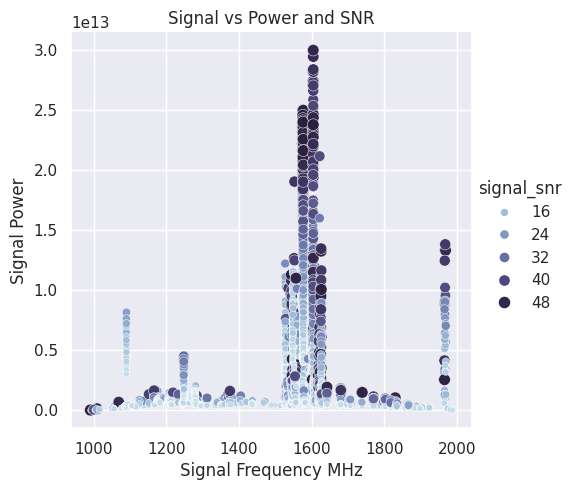

In [33]:
#visualize signal vs power with snr value incuded 
def pow_freq_snr(full_df):
    df_new = full_df
    sns.set_theme()
    sns.relplot(data=df_new, x=df_new["signal_frequency"], y=df_new["signal_power"], 
                hue=df_new["signal_snr"], size = df_new["signal_snr"], palette = "ch:s=.25,rot=-.25")
 
    plt.xlabel("Signal Frequency MHz")
    plt.ylabel("Signal Power")
    plt.title("Signal vs Power and SNR")
    plt.grid(True)
    plt.show()

pow_freq_snr(clean_df)

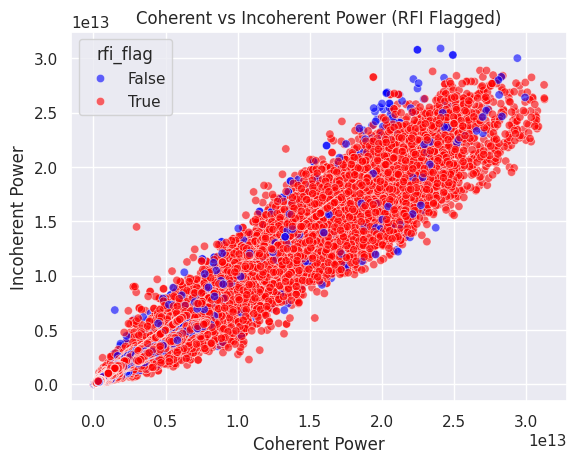

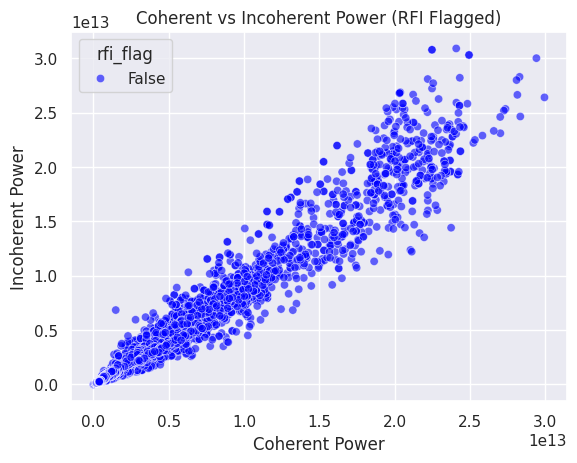

In [34]:
#visualize incoh to coh power with rfi flags included 

df_1 = full_df

sns.scatterplot(
    data=df_1,
    x='signal_power',  # coherent
    y='signal_incoherent_power',
    hue='rfi_flag',
    palette={False: 'blue', True: 'red'},
    alpha=0.6
)
plt.xlabel("Coherent Power")
plt.ylabel("Incoherent Power")
plt.title("Coherent vs Incoherent Power (RFI Flagged)")
plt.grid(True)
plt.show()

df_2 = clean_df
sns.scatterplot(
    data=df_2,
    x='signal_power',  # coherent
    y='signal_incoherent_power',
    hue='rfi_flag',
    palette={False: 'blue', True: 'red'},
    alpha=0.6
)
plt.xlabel("Coherent Power")
plt.ylabel("Incoherent Power")
plt.title("Coherent vs Incoherent Power (RFI Flagged)")
plt.grid(True)
plt.show()

Excess Kurtosis: 10.447502904769626
Skewness: 1.870923684185115


/tmp/ipykernel_51156/1914982559.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_rfi_df['power_ratio'] = non_rfi_df['signal_power'] / (non_rfi_df['signal_incoherent_power'] + 1e-9)


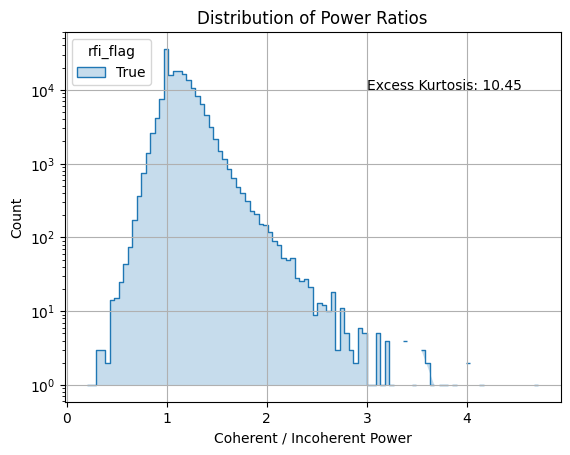

Excess Kurtosis: 2.5908677026272686
Skewness: 0.8972597213443946


/tmp/ipykernel_51156/1914982559.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_rfi_df['power_ratio'] = non_rfi_df['signal_power'] / (non_rfi_df['signal_incoherent_power'] + 1e-9)


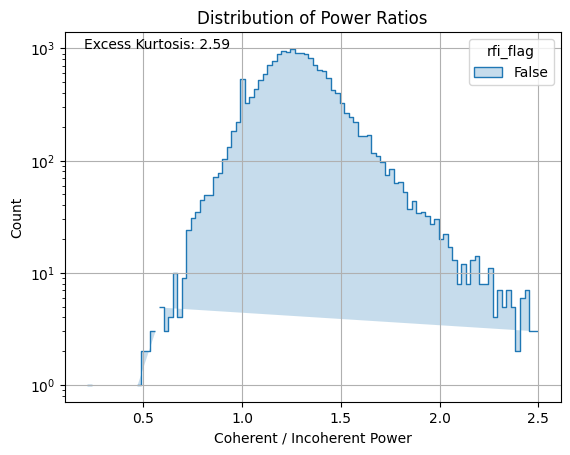

In [23]:
# visualize distribution of power ratios across data set/ time 
from scipy.stats import kurtosis, skew

non_rfi_df = full_df[full_df['rfi_flag'] == True]
ratios = non_rfi_df['signal_power'] / non_rfi_df['signal_incoherent_power']
ratios = ratios.replace([np.inf, -np.inf], np.nan).dropna()
excess_kurt = kurtosis(ratios, fisher=True)
print("Excess Kurtosis:", kurtosis(ratios, fisher=True))  # >0 = heavy tail
print("Skewness:", skew(ratios))

non_rfi_df['power_ratio'] = non_rfi_df['signal_power'] / (non_rfi_df['signal_incoherent_power'] + 1e-9)
sns.histplot(data=non_rfi_df, x='power_ratio', hue='rfi_flag', bins=100, log_scale=(False, True), element='step')  
plt.text(3, 1e4, f'Excess Kurtosis: {excess_kurt:.2f}', fontsize=10)
plt.title("Distribution of Power Ratios")
plt.xlabel("Coherent / Incoherent Power")
plt.grid(True)
plt.show()



non_rfi_df = clean_df
ratios = non_rfi_df['signal_power'] / non_rfi_df['signal_incoherent_power']
ratios = ratios.replace([np.inf, -np.inf], np.nan).dropna()
excess_kurt = kurtosis(ratios, fisher=True)

print("Excess Kurtosis:", kurtosis(ratios, fisher=True))  # >0 = heavy tail
print("Skewness:", skew(ratios))

non_rfi_df['power_ratio'] = non_rfi_df['signal_power'] / (non_rfi_df['signal_incoherent_power'] + 1e-9)
sns.histplot(data=non_rfi_df, x='power_ratio', hue='rfi_flag', bins=100, log_scale=(False, True), element='step')  
plt.text(0.2, 1e3, f'Excess Kurtosis: {excess_kurt:.2f}', fontsize=10)
plt.title("Distribution of Power Ratios")
plt.xlabel("Coherent / Incoherent Power")
plt.grid(True)
plt.show()

clean_df.to_pickle('data/clean_df.pkl')

#save in pickle file in scratch space 

full_df.columns

In [ ]:
def processing(file,start,stop):
    df = pd.read_pickle(f"/datag/users/ctremblay/{file}")
    small_df = df[start:stop]
    columns=['source_name','beam_id','ra_hours' , 'dec_degrees' , 'tstart','signal_frequency', 'signal_beam', 
             'signal_drift_rate', 'signal_snr' , 'signal_power' , 'signal_incoherent_power']
    df_new= small_df[columns]
    #signal_drift_rate == 0 remove
    # S/R > 20 remove 
    grouped_dec = df_new.groupby("dec_degrees")

    dec_dfs={}
    for dec_value, group_df in grouped_dec:
        dec_dfs[dec_value] = group_df  # Save entire group DataFrame
        #print(len(group_df))
       # print(group_df.groupby("ra_hours").size())

    for i, (dec_value, df) in enumerate(dec_dfs.items(), start=1):
        globals()[f"fov_{i}"] = df
    print(len(fov_1))
    print(fov_1.groupby("tstart").size())

    return fov_1.head()
   # print(len(np.unique(df_new['signal_frequency'])))
   # print(df_new.groupby("tstart").size())
   # print(df_new.groupby("ra_hours").size())
   # print(df_new.groupby("signal_frequency").size())


    #return df_new

    

processing('Summer_Project_RA9_Dec0.90.pkl', 0,1000000)


167716
tstart
60069.113731     2230
60069.113829     3740
60069.113926     4634
60069.114411    15698
60069.114508    15110
60069.114605    15737
60069.114702    15544
60069.114799    10009
60069.114897    10796
60069.114994      436
60069.115091      186
60069.115188    14466
60069.115285    13646
60069.115382    13158
60069.115479    12895
60069.115576    11227
60069.115673     8204
dtype: int64


,source_name,beam_id,ra_hours,dec_degrees,tstart,signal_frequency,signal_beam,signal_drift_rate,signal_snr,signal_power,signal_incoherent_power
3,743517082989416704,32100,9.939133,28.7294,60069.113926,1990.883732,3,0.0,10.802960,1.297620e+10,1.243778e+10
22,743517082989416704,32100,9.939133,28.7294,60069.113926,1993.136731,3,0.0,13.276069,1.221296e+10,1.136826e+10
241,743517082989416704,32100,9.939133,28.7294,60069.113926,1572.756985,3,0.0,16.291704,1.014853e+12,9.275462e+11
243,743517082989416704,32100,9.939133,28.7294,60069.113926,1572.697094,3,0.0,9.456708,6.825698e+11,6.960990e+11
245,743517082989416704,32100,9.939133,28.7294,60069.113926,1572.713986,3,0.0,11.549982,7.843343e+11,6.280134e+11


In [ ]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    uniqude_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
        class_index = (labels == k).nonzero()[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    
    plt.tight_layout()
